In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [ ]:
pip install -qU "langchain[google-genai]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


## Messages
Chat models can use messages, which capture different roles within a conversation.

LangChain supports various message types, including HumanMessage, AIMessage, SystemMessage, and ToolMessage.

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Let's create a list of messages.

Each message can be supplied with a few things:

*   content - content of the message
*   name - optionally, a message author
*   response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)

In [ ]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(content=f"So you said you were researching ocean mammals?")]
messages.append(HumanMessage(content=f"Yes, that's right."))
messages.append(AIMessage(content=f"Great, what would you like to learn about."))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US."))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================

So you said you were researching ocean mammals?
================================ Human Message =================================

Yes, that's right.
================================== Ai Message ==================================

Great, what would you like to learn about.
================================ Human Message =================================

I want to learn about the best place to see Orcas in the US.


## Chat Models
Chat models can use a sequence of message as input and support message types, as discussed above.

There are many to choose from! Let's work with GeminiAI.

In [ ]:
import os, getpass
def __set_env(var: str):
  if not os.environ.get(var):
    os.environ[var] = getpass.getpass(f"{var}: ")
__set_env("GOOGLE_API_KEY")

GOOGLE_API_KEY: ··········


In [ ]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("gemini-2.5-flash",model_provider="google_genai")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [ ]:
result

AIMessage(content='That\'s a fantastic goal! Orcas are incredible creatures.\n\nWhen it comes to the "best" place to see Orcas in the US, it really depends on what you\'re looking for, but there are two primary contenders, with a third strong option:\n\n1.  **San Juan Islands, Washington (and surrounding Puget Sound):**\n    *   **Why it\'s often considered the "best":** This region is historically famous for being home to the **Southern Resident Killer Whales (SRKWs)**, a distinct population that primarily eats salmon. The summer months (June to September) were traditionally the most reliable time to see them as they followed the salmon runs.\n    *   **What to expect now:** While still a prime location, the SRKW population is endangered and their movements have become less predictable in recent years due to declining salmon stocks. However, you are now *very* likely to see **Bigg\'s Orcas (or Transient Orcas)** in this area year-round. These are mammal-eating orcas that hunt seals, s

In [ ]:
result.response_metadata

{'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
 'finish_reason': 'STOP',
 'model_name': 'gemini-2.5-flash',
 'safety_ratings': []}

## Tools
Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user.

And, it will return an output that adheres to the tool's schema.

Many LLM providers support tool calling and tool calling interface in LangChain is simple.

In [ ]:
## Multiply function in our tool
def multiply(a: int, b: int) -> int:
  """Multiply a and b.

  Args:
    a: first int
    b: second int

  Returns:
    product of a and b
  """
  return a*b
llm_with_tools = llm.bind_tools([multiply])

If we pass an input - e.g., "What is 2 multiplied by 3" - we see a tool call returned.

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.


```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```



In [ ]:
tool_call = llm_with_tools.invoke([HumanMessage(content="What is 2 multiplied by 3")])

In [ ]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2.0, 'b': 3.0},
  'id': 'e614a620-d6ba-4aae-8256-d40a4a1c6587',
  'type': 'tool_call'}]

## Using messages as state
With these foundations in place, we can now use messages in our graph state.

Let's define our state, ```MessagesState```, as a ```TypedDict``` with a single key: ```messages```.

```messages``` is simply a list of messages, as we defined above (e.g., ```HumanMessage```, etc).

In [ ]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessageState(TypedDict):
  messages: list[AnyMessage]


## Reducers
As we discussed, each node will return a new value for our state key ```messages```.

But, this new value will override the prior ```messages``` value.

As our graph runs, we want to append messages to our ```messages``` state key.

We can use reducer functions to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built ```add_messages``` reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our ```messages``` key with the ```add_messages``` reducer function as metadata.

In [ ]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessageState(TypedDict):
  messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built ```MessagesState```!

```MessagesState``` is defined:

With a pre-build single ```messages``` key
This is a list of ``` AnyMessage``` objects
It uses the ```add_messages``` reducer
We'll usually use ```MessagesState``` because it is less verbose than defining a custom ```TypedDict```, as shown above.

In [ ]:
from langgraph.graph import MessagesState

class MessageState(MessagesState):
  # Add any keys needed beyond messages, which is prebuilt
  pass

To go a bit deeper, we can see how the ```add_messages``` reducer works in isolation.

In [ ]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?"),
                    HumanMessage(content="I'm looking for information on marine biology.")
                   ]
# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are yoy interested in?")

# Test
add_messages(initial_messages, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, id='1a52c90c-afe3-4792-84a0-c3b55517039a'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, id='f75c51f5-d0e0-451d-b332-1eddd6bfef6c'),
 AIMessage(content='Sure, I can help with that. What specifically are yoy interested in?', additional_kwargs={}, response_metadata={}, id='4c75b5f4-2a46-4f25-92e3-c03cd898f1b9')]

## Our graph
Now, lets use ```MessagesState``` with a graph

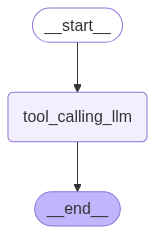

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Node
def tool_calling_llm(state:MessageState):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessageState)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_edge(START,"tool_calling_llm")
builder.add_edge("tool_calling_llm",END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in ```Hello!```, the LLM responds without any tool calls.

In [ ]:
messages = graph.invoke({"messages": [HumanMessage(content="Hello!")]})
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! I'm a calculator bot, I can multiply two numbers for you. How can I help?


In [ ]:
messages = graph.invoke({"messages":HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (aee34058-5d58-4f58-89a0-b31a96d7fb18)
 Call ID: aee34058-5d58-4f58-89a0-b31a96d7fb18
  Args:
    a: 2.0
    b: 3.0
